# SPEACH RECOGNITION WITH MACHINE LEARNING
## Eguivar Villca Shirley Carminia 

# 1. Introduccion

<img src="image1.png">

Luego de tener una visión general sobre las señales acústicas y el proceso de extracción de características , en esta sección se utilizara los conocimientos adquiridos poder resolver el problema de reconocimiento de voz/comandos con machine learning.
La propuesta es desarrollar un modelo de machine learning usando redes neuronales, antes de que el dataset sea procesado por la red neuronal, este debe pasar por una fase pre-procesado, dado que la red no puede trabajar con los archivos de audio como entradas.
Al momento de preprocesar los archivos de audio se pueden optar por dos enfoques

* Obtener los espectogramas(ya descritos anteriormente) y diseñar una red que trabaje con imagenes como entradas.
* Obtener los caracteristicas y tratarlos como vectores de numeros y usar esos como entradas de la red neuronal.

En el presente proyecto se opto por el segundo enfoque.El procesado de audio requiere una serie de operaciones a realizar de forma secuencial  en cada uno de los archivos de audio que permita extraer los atributos o caracteristicasmas relevantes que en su conjunto compondran el dataset.


In [3]:
#pip install keras
#pip install pydot
#!pip install graphviz
#pip install pygraphviz

In [4]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

# 2. Audioset

El audioset seleccionado contiene 30 carpetas, cada una de ellas representa una palabra y dentro se encuentran los archivos de audios que corresponden a dicha palabra.
Cada carpeta en promedio contiene 2300 archivos de audio por lo que se tendrá un total de 69000 archivos en promedio para trabajar.

Fuente: http://www.openslr.org/45/

# 3. Audio Processing 

## 3.1. Extraccion de los espectogramaspor cada audio

In [37]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))

commands = 'bed bird cat dog down eight five four go happy house left marvin nine no off on one right seven sheila six stop three tree two up wow yes zero'.split()

for g in commands:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'audioset/{g}'):        
        songname = f'audioset/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
        

<Figure size 720x720 with 0 Axes>

## 3.2. Extraccion de las caracteristicas/atributos a partir de los espectogramas


* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [4]:

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# 4. Ensamblado del dataset en un .csv

In [39]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
commands = 'bed bird cat dog down eight five four go happy house left marvin nine no off on one right seven sheila six stop three tree two up wow yes zero'.split()
for g in commands:
    for filename in os.listdir(f'audioset/{g}'):
        songname = f'audioset/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)[0]
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

# 5. Analysing the Data in Pandas

In [66]:
data = pd.read_csv('dataset.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,00176480_nohash_0.wav,0.536929,0.046897,1866.957312,1646.276495,3798.408092,0.129949,-438.608368,75.281525,-6.127647,...,-5.488950,-4.808288,-0.912599,2.830438,-3.125182,-3.778586,0.305113,2.306514,-0.241880,bed
1,004ae714_nohash_0.wav,0.549667,0.021958,2549.482652,1784.076397,4499.950062,0.094760,-437.306030,55.608288,-69.100243,...,-0.743252,16.089277,-3.088644,6.929111,-1.886991,3.923231,4.249386,-1.411346,5.704595,bed
2,004ae714_nohash_1.wav,0.597667,0.012081,2541.917660,1783.815263,4520.659656,0.081221,-463.436920,68.505119,-81.329170,...,0.421176,16.382978,-2.875346,9.386302,-6.103157,5.518322,4.254614,2.941181,4.928066,bed
3,00f0204f_nohash_0.wav,0.329791,0.007394,1571.970794,1741.780001,3512.848455,0.050482,-512.929810,121.430000,-19.593218,...,-9.092706,6.511714,-5.415683,-4.136275,-6.304612,4.045578,-5.118494,-7.106812,1.639770,bed
4,00f0204f_nohash_1.wav,0.365830,0.007248,1535.506265,1757.685320,3514.561324,0.051591,-520.451538,119.791626,-15.088761,...,-5.792112,6.994162,-4.331662,-3.106207,-6.058243,4.206815,-3.870832,-4.328875,4.575784,bed


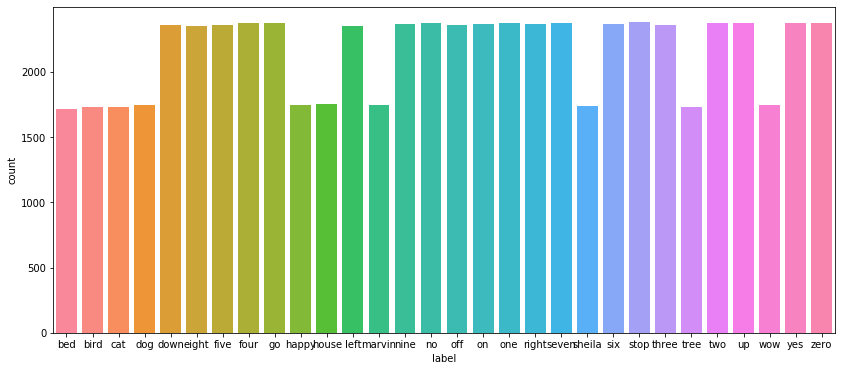

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
sns.countplot('label',data=data ,saturation=5)

In [68]:
data.shape

(64721, 28)

# 5.1.  Limpieza de datos

## Borrando Columnas innecesarias

In [69]:
data = data.drop(['filename'],axis=1)

## Codificndo etiquetas

In [70]:

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

## Scaling the Feature columns

In [71]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [72]:
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.536929,0.046897,1866.957312,1646.276495,3798.408092,0.129949,-438.608368,75.281525,-6.127647,28.258123,...,-5.488950,-4.808288,-0.912599,2.830438,-3.125182,-3.778586,0.305113,2.306514,-0.241880,bed
1,0.549667,0.021958,2549.482652,1784.076397,4499.950062,0.094760,-437.306030,55.608288,-69.100243,81.233757,...,-0.743252,16.089277,-3.088644,6.929111,-1.886991,3.923231,4.249386,-1.411346,5.704595,bed
2,0.597667,0.012081,2541.917660,1783.815263,4520.659656,0.081221,-463.436920,68.505119,-81.329170,88.987152,...,0.421176,16.382978,-2.875346,9.386302,-6.103157,5.518322,4.254614,2.941181,4.928066,bed
3,0.329791,0.007394,1571.970794,1741.780001,3512.848455,0.050482,-512.929810,121.430000,-19.593218,44.188293,...,-9.092706,6.511714,-5.415683,-4.136275,-6.304612,4.045578,-5.118494,-7.106812,1.639770,bed
4,0.365830,0.007248,1535.506265,1757.685320,3514.561324,0.051591,-520.451538,119.791626,-15.088761,41.959892,...,-5.792112,6.994162,-4.331662,-3.106207,-6.058243,4.206815,-3.870832,-4.328875,4.575784,bed


# 6. Dividing data into training and Testing set

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [74]:
len(y_train)

45304

In [75]:
len(y_test)

19417

In [76]:
#X_train[10]
X_train[0]

array([-0.1255137 ,  0.28187076,  3.19622952,  0.98801444,  2.37737795,
        2.24342822,  1.05105349, -1.5101421 , -0.78083564,  2.44631796,
       -2.06826396,  3.05307231, -2.5666674 ,  3.09825965,  0.18009197,
        0.97090012,  2.00372557, -0.61738748,  1.33232828, -0.67540639,
        2.68491019, -0.72503151,  1.83424513,  0.74173996,  1.41768662,
       -0.14194348])

#  7. Classification with Keras

# Building our Network

* Creamos el modelo de tipo secuencial
* Creamos las capas


In [77]:
from keras import models
from keras import layers

snn_model  = models.Sequential()

snn_model .add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))

snn_model .add(layers.Dense(256, activation='relu'))

snn_model.add(layers.Dense(128, activation='relu'))

snn_model.add(layers.Dense(64, activation='relu'))

snn_model.add(layers.Dense(30, activation='softmax'))

In [78]:
snn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               13824     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1950      
Total params: 188,254
Trainable params: 188,254
Non-trainable params: 0
_________________________________________________________________


In [79]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(snn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

### Realizando ajustes en el modelo

Con esto indicamos el tipo de pérdida (loss) que utilizaremos, el optimizador de los pesos de las conexiones de las neuronas y las métricas que queremos obtener

In [82]:
snn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# 8. Entrenamiento de la Red
Indicamos con model.fit() las entradas y sus salidas y la cantidad de iteraciones de aprendizaje (epochs) de entrenamiento. 


In [83]:
tic=time.time()
snn  = snn_model.fit(X_train,
                     y_train,
                     epochs= 1000,#150
                     batch_size= 500
                    )
print('Tiempo: {} secs'.format(time.time()-tic))

Epoch 1/1000
45304/45304 [==============================] - 1s 24us/step - loss: 2.7657 - accuracy: 0.2018
Epoch 2/1000
45304/45304 [==============================] - 1s 17us/step - loss: 2.2954 - accuracy: 0.3233
Epoch 3/1000
45304/45304 [==============================] - 1s 18us/step - loss: 2.1709 - accuracy: 0.3573 0s - loss: 2
Epoch 4/1000
45304/45304 [==============================] - 1s 18us/step - loss: 2.0883 - accuracy: 0.3770
Epoch 5/1000
45304/45304 [==============================] - 1s 17us/step - loss: 2.0183 - accuracy: 0.3954
Epoch 6/1000
45304/45304 [==============================] - 1s 17us/step - loss: 1.9627 - accuracy: 0.4107
Epoch 7/1000
45304/45304 [==============================] - 1s 18us/step - loss: 1.9083 - accuracy: 0.4239
Epoch 8/1000
45304/45304 [==============================] - 1s 17us/step - loss: 1.8685 - accuracy: 0.4342
Epoch 9/1000
45304/45304 [==============================] - 1s 18us/step - loss: 1.8212 - accuracy: 0.4477
Epoch 10/1000
45304/4530

45304/45304 [==============================] - 1s 22us/step - loss: 0.4316 - accuracy: 0.8599
Epoch 76/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.4144 - accuracy: 0.8661
Epoch 77/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.3930 - accuracy: 0.8737
Epoch 78/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.3738 - accuracy: 0.8818
Epoch 79/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.3646 - accuracy: 0.8840
Epoch 80/1000
45304/45304 [==============================] - 1s 19us/step - loss: 0.3809 - accuracy: 0.8768
Epoch 81/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.3516 - accuracy: 0.8877
Epoch 82/1000
45304/45304 [==============================] - 1s 19us/step - loss: 0.3447 - accuracy: 0.8906
Epoch 83/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.3428 - accuracy: 0.8907
Epoch 84/1000
45304/45304 [===============

45304/45304 [==============================] - 1s 24us/step - loss: 0.0185 - accuracy: 0.9980
Epoch 150/1000
45304/45304 [==============================] - 1s 25us/step - loss: 0.0163 - accuracy: 0.9983
Epoch 151/1000
45304/45304 [==============================] - 1s 23us/step - loss: 0.0161 - accuracy: 0.9985
Epoch 152/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0176 - accuracy: 0.9979
Epoch 153/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0244 - accuracy: 0.9964
Epoch 154/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0796 - accuracy: 0.9759
Epoch 155/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.5719 - accuracy: 0.8343
Epoch 156/1000
45304/45304 [==============================] - 1s 19us/step - loss: 0.4668 - accuracy: 0.8558
Epoch 157/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.2602 - accuracy: 0.9114
Epoch 158/1000
45304/45304 [======

45304/45304 [==============================] - 1s 21us/step - loss: 0.1794 - accuracy: 0.9498
Epoch 224/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.7515 - accuracy: 0.8019
Epoch 225/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.3208 - accuracy: 0.8966
Epoch 226/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.1271 - accuracy: 0.9563
Epoch 227/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0620 - accuracy: 0.9824
Epoch 228/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0296 - accuracy: 0.9947
Epoch 229/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0143 - accuracy: 0.9989
Epoch 230/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0104 - accuracy: 0.9990
Epoch 231/1000
45304/45304 [==============================] - 1s 19us/step - loss: 0.0086 - accuracy: 0.9992
Epoch 232/1000
45304/45304 [======

45304/45304 [==============================] - 1s 21us/step - loss: 0.2297 - accuracy: 0.9228
Epoch 299/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.1063 - accuracy: 0.9651
Epoch 300/1000
45304/45304 [==============================] - 1s 28us/step - loss: 0.0488 - accuracy: 0.9860
Epoch 301/1000
45304/45304 [==============================] - 1s 27us/step - loss: 0.0180 - accuracy: 0.9972
Epoch 302/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0075 - accuracy: 0.9996
Epoch 303/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0053 - accuracy: 0.9997
Epoch 304/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0052 - accuracy: 0.9997
Epoch 305/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0046 - accuracy: 0.9997
Epoch 306/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0045 - accuracy: 0.9997
Epoch 307/1000
45304/45304 [======

45304/45304 [==============================] - 1s 22us/step - loss: 0.0682 - accuracy: 0.9775
Epoch 372/1000
45304/45304 [==============================] - 2s 36us/step - loss: 0.0334 - accuracy: 0.9914
Epoch 373/1000
45304/45304 [==============================] - 1s 31us/step - loss: 0.0137 - accuracy: 0.9981
Epoch 374/1000
45304/45304 [==============================] - 2s 33us/step - loss: 0.0058 - accuracy: 0.9996 0s - loss: 0.0058 - accu
Epoch 375/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0037 - accuracy: 0.9998
Epoch 376/1000
45304/45304 [==============================] - 1s 31us/step - loss: 0.0032 - accuracy: 0.9999
Epoch 377/1000
45304/45304 [==============================] - 2s 35us/step - loss: 0.0033 - accuracy: 0.9997
Epoch 378/1000
45304/45304 [==============================] - 1s 28us/step - loss: 0.0031 - accuracy: 0.9998
Epoch 379/1000
45304/45304 [==============================] - 2s 40us/step - loss: 0.0035 - accuracy: 0.9996
Epoch 380

45304/45304 [==============================] - 1s 22us/step - loss: 0.0074 - accuracy: 0.9993
Epoch 446/1000
45304/45304 [==============================] - 1s 23us/step - loss: 0.0039 - accuracy: 0.9998
Epoch 447/1000
45304/45304 [==============================] - 2s 47us/step - loss: 0.0029 - accuracy: 0.9999
Epoch 448/1000
45304/45304 [==============================] - 2s 37us/step - loss: 0.0025 - accuracy: 0.9998
Epoch 449/1000
45304/45304 [==============================] - 2s 37us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 450/1000
45304/45304 [==============================] - 2s 35us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 451/1000
45304/45304 [==============================] - 1s 32us/step - loss: 0.0018 - accuracy: 0.9999
Epoch 452/1000
45304/45304 [==============================] - 1s 30us/step - loss: 0.0022 - accuracy: 0.9998
Epoch 453/1000
45304/45304 [==============================] - 2s 37us/step - loss: 0.0022 - accuracy: 0.9998
Epoch 454/1000
45304/45304 [======

45304/45304 [==============================] - 1s 23us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 516/1000
45304/45304 [==============================] - 1s 24us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 517/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 518/1000
45304/45304 [==============================] - 1s 23us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 519/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 520/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 521/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 522/1000
45304/45304 [==============================] - 1s 23us/step - loss: 0.0011 - accuracy: 1.0000 0s - loss: 0
Epoch 523/1000
45304/45304 [==============================] - 1s 26us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 524/1000
45304/

45304/45304 [==============================] - 2s 34us/step - loss: 9.3180e-04 - accuracy: 1.0000
Epoch 589/1000
45304/45304 [==============================] - 1s 31us/step - loss: 0.0047 - accuracy: 0.9991 0s -
Epoch 590/1000
45304/45304 [==============================] - 1s 32us/step - loss: 0.2797 - accuracy: 0.9265
Epoch 591/1000
45304/45304 [==============================] - 1s 25us/step - loss: 0.4961 - accuracy: 0.8615
Epoch 592/1000
45304/45304 [==============================] - 1s 23us/step - loss: 0.1688 - accuracy: 0.9436
Epoch 593/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0559 - accuracy: 0.9815
Epoch 594/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0175 - accuracy: 0.9960
Epoch 595/1000
45304/45304 [==============================] - 1s 24us/step - loss: 0.0049 - accuracy: 0.9998
Epoch 596/1000
45304/45304 [==============================] - 1s 29us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 597/1000
45304/4530

Epoch 662/1000
45304/45304 [==============================] - 1s 26us/step - loss: 8.5251e-04 - accuracy: 1.0000
Epoch 663/1000
45304/45304 [==============================] - 1s 23us/step - loss: 8.0846e-04 - accuracy: 1.0000
Epoch 664/1000
45304/45304 [==============================] - 1s 21us/step - loss: 7.7888e-04 - accuracy: 1.0000
Epoch 665/1000
45304/45304 [==============================] - 1s 20us/step - loss: 7.3647e-04 - accuracy: 1.0000
Epoch 666/1000
45304/45304 [==============================] - 1s 20us/step - loss: 7.0408e-04 - accuracy: 1.0000
Epoch 667/1000
45304/45304 [==============================] - 1s 21us/step - loss: 6.7302e-04 - accuracy: 1.0000
Epoch 668/1000
45304/45304 [==============================] - 1s 21us/step - loss: 6.5344e-04 - accuracy: 1.0000
Epoch 669/1000
45304/45304 [==============================] - 1s 22us/step - loss: 6.2635e-04 - accuracy: 1.0000
Epoch 670/1000
45304/45304 [==============================] - 1s 23us/step - loss: 6.0258e-04 - 

45304/45304 [==============================] - 1s 20us/step - loss: 0.3773 - accuracy: 0.9102
Epoch 736/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.6175 - accuracy: 0.8331
Epoch 737/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.1478 - accuracy: 0.9506
Epoch 738/1000
45304/45304 [==============================] - 1s 19us/step - loss: 0.0441 - accuracy: 0.9867
Epoch 739/1000
45304/45304 [==============================] - 1s 19us/step - loss: 0.0126 - accuracy: 0.9982
Epoch 740/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0047 - accuracy: 0.9999
Epoch 741/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 742/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 743/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 744/1000
45304/45304 [======

45304/45304 [==============================] - 1s 25us/step - loss: 0.0018 - accuracy: 1.0000 0s - loss: 0.0018 - accuracy: 
Epoch 809/1000
45304/45304 [==============================] - 1s 23us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 810/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 811/1000
45304/45304 [==============================] - 1s 23us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 812/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 813/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 814/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 815/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 816/1000
45304/45304 [==============================] - 1s 20us/step - loss: 9.5828e-04 - accuracy: 1.0000

45304/45304 [==============================] - 1s 24us/step - loss: 0.1010 - accuracy: 0.9656 0s - loss: 0.1063 - accuracy: 
Epoch 881/1000
45304/45304 [==============================] - 1s 24us/step - loss: 0.0317 - accuracy: 0.9905
Epoch 882/1000
45304/45304 [==============================] - 1s 23us/step - loss: 0.0101 - accuracy: 0.9982
Epoch 883/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0036 - accuracy: 0.9998
Epoch 884/1000
45304/45304 [==============================] - 1s 19us/step - loss: 0.0026 - accuracy: 0.9998
Epoch 885/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0020 - accuracy: 0.9999
Epoch 886/1000
45304/45304 [==============================] - 1s 22us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 887/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 888/1000
45304/45304 [==============================] - 1s 21us/step - loss: 0.0012 - accuracy: 1.0000
Epo

45304/45304 [==============================] - 1s 20us/step - loss: 6.2889e-04 - accuracy: 1.0000
Epoch 953/1000
45304/45304 [==============================] - 1s 24us/step - loss: 5.9718e-04 - accuracy: 1.0000
Epoch 954/1000
45304/45304 [==============================] - 1s 22us/step - loss: 5.6857e-04 - accuracy: 1.0000
Epoch 955/1000
45304/45304 [==============================] - 1s 21us/step - loss: 5.4010e-04 - accuracy: 1.0000
Epoch 956/1000
45304/45304 [==============================] - 1s 21us/step - loss: 5.1638e-04 - accuracy: 1.0000
Epoch 957/1000
45304/45304 [==============================] - 1s 20us/step - loss: 4.9794e-04 - accuracy: 1.0000
Epoch 958/1000
45304/45304 [==============================] - 1s 19us/step - loss: 4.7446e-04 - accuracy: 1.0000
Epoch 959/1000
45304/45304 [==============================] - 1s 20us/step - loss: 4.6010e-04 - accuracy: 1.0000
Epoch 960/1000
45304/45304 [==============================] - 1s 20us/step - loss: 0.0010 - accuracy: 0.9998
Ep

# 8.1. Evaluacion

# 8.1.1. Training

In [84]:
results = snn_model.evaluate(X_train, y_train)
print(results)
print("%s: %.2f%%" % (snn_model.metrics_names[1], results[1]*100))

45304/45304 [==============================] - 1s 26us/step
[0.015218673777284171, 0.997285008430481]
accuracy: 99.73%


# 8.1.1. Test

In [99]:
results_test = snn_model.evaluate(X_test, y_test)
print(results_test)
print("%s: %.2f%%" % (snn_model.metrics_names[1], results_test[1]*100))

19417/19417 [==============================] - 0s 22us/step
[6.817297667070012, 0.4278724789619446]
accuracy: 42.79%


# 9. Predictions


# 9.1. Predictions on Test Data

In [101]:
# make class predictions with the model
x_pred = snn_model.predict_classes(X_test)

x_pred = encoder.inverse_transform(x_pred)
y_pred =encoder.inverse_transform(y_test) 

# summarize the first 100 cases
for i in range(100):
    print('%s => %s (expected %s)' % (X_test[i].tolist(), x_pred[i], y_pred[i]))

[-0.41492188662674456, -0.4600910792050162, -0.16888231999052378, 0.2862022281576949, 0.08596664714166913, -0.20682986407545778, -1.027585842087952, -0.17986512944254832, 1.593661348026747, -0.5552349899299939, 1.2738788973560968, -0.4056918324437419, 1.0154976633114412, -0.10120394388841164, -0.4733504901775777, -0.9005530689179445, 0.12288298647892237, 1.5329185177787374, -0.4354409816906578, 0.8781497584671194, 0.0944756147152046, 1.5564445426435118, 0.41239224679372793, -1.129634016064911, -0.61807772489041, -0.2910317067690421] => no (expected one)
[0.7982602155019614, -0.6699713399633084, -0.05765787642366443, 0.8599780421932536, 0.5556803163299, -0.34770814300311836, -1.2103474029797208, -0.7826415516153441, 1.4689340304987837, -1.3016851713743394, 1.0897915476592828, 0.4357295236474248, 1.389236813969653, -1.079570589798483, -0.1634113817056754, -0.08651573738272343, 0.1285255772701189, 1.2166666049354304, -1.001003213013239, 1.457066088745066, -0.3334674865677304, -0.398219837